#Sentiment analysis:



The goal is to perform sentiment analysis on text data:

https://www.kaggle.com/competitions/sentiment-analysis-on-movie-reviews/data


About the data:

The dataset is comprised of tab-separated files with phrases from the Rotten Tomatoes dataset. The train/test split has been preserved for the purposes of benchmarking, but the sentences have been shuffled from their original order. Each Sentence has been parsed into many phrases by the Stanford parser. Each phrase has a PhraseId. Each sentence has a SentenceId. Phrases that are repeated (such as short/common words) are only included once in the data.

This is a multi class classification problem such that we have to train a model to predict whether the review is of polarity between 0-4, where 0 being negative and 4 being positive

In [ ]:
#importing neccessary libraries:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
!unzip train.tsv.zip


Archive:  train.tsv.zip
  inflating: train.tsv               
Archive:  test.tsv.zip
  inflating: test.tsv                


In [ ]:
#loading the train and testset:

df_train= pd.read_csv('train.tsv', sep='\t')


print('Training data shape = {}'.format(df_train.shape))


Training data shape = (156060, 4)
Test data shape = (66292, 3)


In [ ]:
(df_train.head())

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [ ]:
for val in df_train[df_train['Sentiment']==4]['Phrase'].tolist()[0:5]:
  print(val)

This quiet , introspective and entertaining independent is worth seeking .
quiet , introspective and entertaining independent
entertaining
is worth seeking
A positively thrilling combination of ethnography and all the intrigue , betrayal , deceit and murder of a Shakespearean tragedy or a juicy soap opera


In [ ]:
for val in df_train[df_train['Sentiment']==0]['Phrase'].tolist()[0:5]:
  print(val)

would have a hard time sitting through this one
have a hard time sitting through this one
Aggressive self-glorification and a manipulative whitewash
self-glorification and a manipulative whitewash
Trouble Every Day is a plodding mess .


In [ ]:
for val in df_train[df_train['Sentiment']==3]['Phrase'].tolist()[0:5]:
  print(val)

good for the goose
good
amuses
This quiet , introspective and entertaining independent
quiet , introspective and entertaining


In [ ]:
for val in df_train[df_train['Sentiment']==2]['Phrase'].tolist()[0:5]:
  print(val)

A series of escapades demonstrating the adage that what is good for the goose
A series
A
series
of escapades demonstrating the adage that what is good for the goose


In [ ]:
for val in df_train[df_train['Sentiment']==1]['Phrase'].tolist()[0:5]:
  print(val)

A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .
the gander , some of which occasionally amuses but none of which amounts to much of a story
but none of which amounts to much of a story
none of which amounts to much of a story
Even fans of Ismail Merchant 's work , I suspect , would have a hard time sitting through this one .


In [ ]:
train_data = df_train.drop(['PhraseId','SentenceId'],axis = 1)


In [ ]:
df_train.Sentiment.value_counts()

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

#Data preprocessing

In [ ]:
from nltk.corpus import stopwords
import re
def text_cleaning(text):
    forbidden_words = set(stopwords.words('english'))
    if text:
        text = ' '.join(text.split('.'))
        text = re.sub('\/',' ',text)
        text = re.sub(r'\\',' ',text)
        text = re.sub(r'((http)\S+)','',text)
        text = re.sub(r'\s+', ' ', re.sub('[^A-Za-z]', ' ', text.strip().lower())).strip()
        text = re.sub(r'\W+', ' ', text.strip().lower()).strip()
        text = [word for word in text.split() if word not in forbidden_words]
        return  ' '.join(text)
    return ' '.join(text)

In [ ]:
train_data['Phrase']= train_data['Phrase'].apply(text_cleaning)


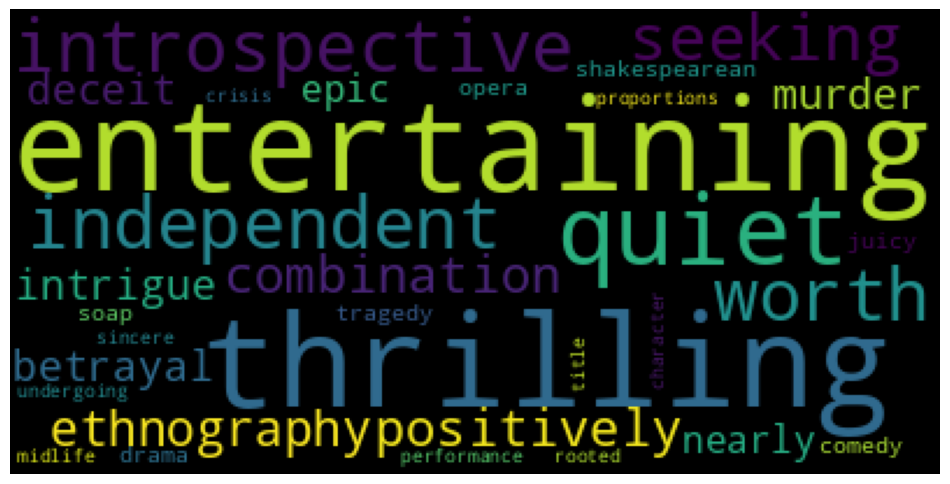

In [ ]:
#creating wordcloud
def create_corpus(df2, target):
    corpus=[]

    for x in df2[df2['Sentiment']==target]['Phrase'].str.split():
        for i in x:
            corpus.append(i)
    return corpus


corpus1= create_corpus(train_data, 4)

from wordcloud import WordCloud
plt.figure(figsize=(12,8))
word_cloud= WordCloud().generate(" ".join(corpus1[0:50]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

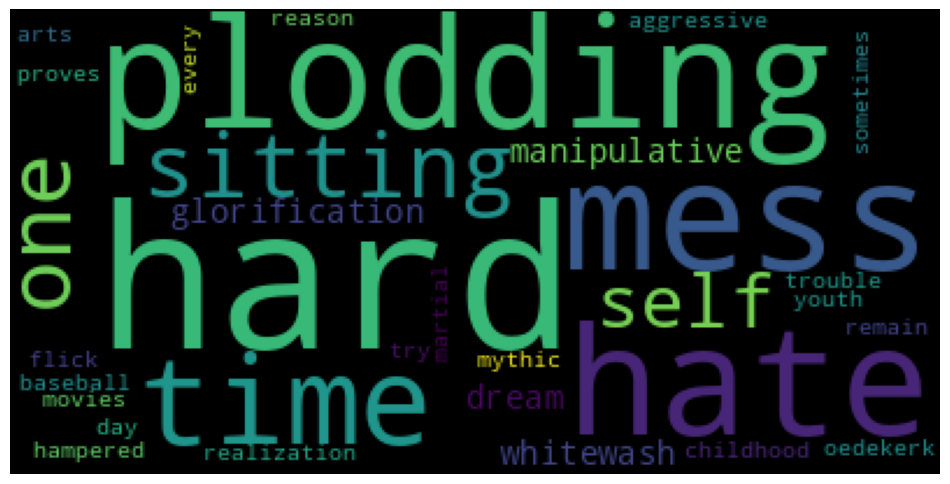

In [ ]:

corpus1= create_corpus(train_data, 0)
plt.figure(figsize=(12,8))
word_cloud= WordCloud().generate(" ".join(corpus1[0:50]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [ ]:
train_d= train_data[~(pd.isnull(train_data['Phrase']))]

from sklearn.model_selection import train_test_split
trainx, testx, trainy, testy= train_test_split(train_d['Phrase'],train_d['Sentiment'], test_size= 0.2, random_state=42)


#Training the model

In [ ]:
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


### Tokenizer to split the text and convert into numbers, we pad the sequences, to ensure we get the text of same length.

In [ ]:
tokenize = Tokenizer()
tokenize.fit_on_texts(trainx.values)


X_train= tokenize.texts_to_sequences(trainx)
X_test = tokenize.texts_to_sequences(testx)

X_train = pad_sequences(X_train)
X_test = pad_sequences(X_test)

## Defining the model

In [ ]:
EMBEDDING_DIM = 100
unknown = len(tokenize.word_index)+1
model = Sequential()
model.add(layers.Embedding(unknown, EMBEDDING_DIM))
model.add(layers.LSTM(units=128, dropout=0.2, recurrent_dropout=0.2 ))
model.add(layers.Dense(5, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         1498200   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 5)                 645       
                                                                 
Total params: 1,616,093
Trainable params: 1,616,093
Non-trainable params: 0
_________________________________________________________________


## Training the model

In [ ]:
model.fit(X_train, trainy, batch_size=128, epochs=5, verbose=1)

Epoch 1/5
976/976 [==============================] - 286s 288ms/step - loss: 0.9924 - accuracy: 0.6021
Epoch 2/5
976/976 [==============================] - 257s 263ms/step - loss: 0.7981 - accuracy: 0.6731
Epoch 3/5
976/976 [==============================] - 260s 266ms/step - loss: 0.7332 - accuracy: 0.6961
Epoch 4/5
976/976 [==============================] - 259s 266ms/step - loss: 0.6825 - accuracy: 0.7141
Epoch 5/5
976/976 [==============================] - 263s 269ms/step - loss: 0.6412 - accuracy: 0.7286


In [ ]:
final_pred = model.predict(X_test)
final_pred

976/976 [==============================] - 16s 15ms/step


array([[4.6821632e-03, 3.5254970e-01, 6.4059776e-01, 1.9989968e-03,
        1.7147060e-04],
       [1.7067761e-05, 2.1057579e-04, 3.1894647e-02, 7.1300054e-01,
        2.5487706e-01],
       [1.2029789e-04, 8.3878702e-03, 9.4148481e-01, 4.9586155e-02,
        4.2072445e-04],
       ...,
       [2.2335980e-02, 1.2966897e-01, 7.7078539e-01, 7.3531598e-02,
        3.6779705e-03],
       [9.9115970e-04, 6.7467541e-02, 7.8753227e-01, 1.4239663e-01,
        1.6124075e-03],
       [1.1454143e-03, 1.7733427e-02, 5.5776423e-01, 3.9137942e-01,
        3.1977560e-02]], dtype=float32)

In [ ]:
classes_x=np.argmax(final_pred,axis=1)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [ ]:
print(classification_report(classes_x,testy))
print("-"*100)
print(confusion_matrix(classes_x,testy))
print("-"*100)

print(accuracy_score(classes_x,testy))

              precision    recall  f1-score   support

           0       0.46      0.51      0.48      1284
           1       0.51      0.57      0.54      4941
           2       0.81      0.74      0.78     17171
           3       0.56      0.59      0.58      6412
           4       0.40      0.55      0.47      1404

    accuracy                           0.66     31212
   macro avg       0.55      0.59      0.57     31212
weighted avg       0.68      0.66      0.67     31212

----------------------------------------------------------------------------------------------------
[[  654   510   108    12     0]
 [  630  2821  1350   131     9]
 [  116  1988 12725  2238   104]
 [   12   196  1392  3777  1035]
 [    4    12    64   549   775]]
----------------------------------------------------------------------------------------------------
0.664872484941689


End Notes : Multi class Sentiment classification on text can be done via multiple ways, with recent progress in LLMs, BERT based models, can be readily applied to perform sentiment classification.

Extra things to try:

1. Using Word2vec embeddings & Xgboost classifier to compare the performance vs deep learning
2. Using BERTforSequenceClassification, to perform multi class classification.